* David Araujo Garcia 1671077
* Enric Ortega Barreda 1672973

# Introducció

* L'objectiu principal d'aquest treball és analitzar i processar una base de dades d'imatges extretes de tràilers de pel·lícules per a tasques de predicció de frames. La base de dades ha estat construïda consolidant frames de diverses pel·lícules, extrets directament dels seus tràilers.

# Recopilació de dades pel Dataset

* Per a aquest treball no hem utilitzat cap base de dades disponible a internet, sinó que n’hem creat una de pròpia. Per fer-ho, inicialment hem descarregat els tràilers de deu pel·lícules diferents. A partir d’aquests tràilers, hem extret 10 fragments de 5 segons per a cada pel·lícula i, posteriorment, hem generat els frames corresponents per tal de construir una base de dades amb un total de deu fragments per a cada pel·lícula.




Per automatitzar el procés i ser més eficients, hem desenvolupat un programa en Python que retalla automàticament cada tràiler en fragments de 5 segons. Aquesta eina ens ha permès processar tots els tràilers de manera ràpida i uniforme, assegurant que cada pel·lícula estigui representada amb fragments consistents.


In [1]:
from moviepy.video.io.VideoFileClip import VideoFileClip

def recortar_video_en_fragmentos(video_path, output_folder, duration=5):
    video = VideoFileClip(video_path)
    video_duration = video.duration  
    fragmentos = int(video_duration // duration)  
    
    for i in range(fragmentos):
        start_time = i * duration
        end_time = start_time + duration
        
        fragment = video.subclip(start_time, end_time)
        
        output_path = f"{output_folder}/fragmento_{i+1}.mp4"
        fragment.write_videofile(output_path, codec="libx264")
    
    if video_duration % duration != 0:
        start_time = fragmentos * duration
        fragment = video.subclip(start_time, video_duration)
        output_path = f"{output_folder}/fragmento_{fragmentos + 1}.mp4"
        fragment.write_videofile(output_path, codec="libx264")



Un cop retallat el tràiler en fragments de 5 segons, hem seleccionat aquells que millor s’adaptaven a les necessitats del nostre model. Hem prioritzat els fragments amb menys transicions abruptes, menys fosos a negre i escenes més uniformes. Aquest procés ens ha permès crear una base de dades més homogènia i optimitzada per garantir un millor rendiment durant l’entrenament del model.


Després de seleccionar els fragments més adequats per a cada pel·lícula, hem desenvolupat un programa per automatitzar el procés de conversió de vídeo a frames. L’objectiu és desglossar cada fragment seleccionat en imatges fixes que puguin ser utilitzades com a dades d’entrada per al model. 


In [2]:
import cv2
import os
from datetime import datetime

def video_to_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"FPS: {fps}, Total Frames: {frame_count}")

    frame_num = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break

        frame_filename = os.path.join(output_folder, f"{timestamp}_frame_{frame_num:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

        frame_num += 1

    video.release()
    print(f"Extracción completada. Frames guardados en {output_folder}")



Per enriquir el nostre dataset amb informació addicional sobre cada frame, hem calculat dues característiques visuals: **brillantor promig** i **contrast**. 

1. **Brillantor Promig**: Aquesta característica mesura la lluminositat general d’un frame. Es calcula convertint la imatge al format HSV i obtenint la mitjana del canal de valor (V), que representa la brillantor de cada píxel.

2. **Contrast**: Aquesta característica quantifica la diferència entre els píxels més foscos i més clars d’un frame. Es calcula com la diferència entre els valors màxim i mínim de la imatge en escala de grisos.

Amb aquestes dues característiques, podem analitzar la qualitat visual de cada frame i incloure informació rellevant que podria influir en el rendiment del model o ser útil en anàlisis posteriors.


In [ ]:
import cv2
import numpy as np
import pandas as pd

def calcular_brillantor_promig(frame_path):
    frame = cv2.imread(frame_path)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    brillantor = np.mean(hsv[:, :, 2]) 
    return brillantor

def calcular_contrast(frame_path):
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) 
    contrast = np.max(frame) - np.min(frame)
    return contrast

Per tal de consolidar la informació de tots els frames en un únic dataset estructurat, hem creat una funció que automatitza el procés d'afegir dades de cada carpeta de frames al fitxer CSV definitiu. Aquesta funció, `agregar_carpeta_al_csv`, no només registra atributs bàsics com la ruta de cada imatge, el nom de la pel·lícula i el número de frame, sinó que també inclou característiques visuals com el **contrast** i la **brillantor promig** per enriquir el dataset.


In [3]:
import os
import csv

def agregar_carpeta_al_csv(carpeta_imagenes, archivo_csv, nombre_pelicula):
   
    with open(archivo_csv, mode='a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        
        if os.stat(archivo_csv).st_size == 0:
            writer.writerow(['ruta_imatge', 'pel·licula', 'Nombre_frame','Contrast','Brillantor_promig'])  

        frame_numero = 1  
        for nombre_imagen in sorted(os.listdir(carpeta_imagenes)):
            ruta_imagen = os.path.join(carpeta_imagenes, nombre_imagen)
            
            if os.path.isfile(ruta_imagen) and nombre_imagen.lower().endswith(('.jpg')):
                frame_numero_formateado = "'" + str(frame_numero).zfill(4)
                Contraste=calcular_contrast(ruta_imagen)
                Brillo_promedio = calcular_brillantor_promig(ruta_imagen)
                writer.writerow([ruta_imagen, nombre_pelicula, frame_numero_formateado, Contraste, Brillo_promedio ])
                
                frame_numero += 1

    print(f"Información de la carpeta '{carpeta_imagenes}' añadida al archivo CSV '{archivo_csv}'")


# 1. EDA (exploratory data analysis)

In [6]:
import pandas as pd
path = 'C:/Users/enric/APC/CAS_KAGGLE/FRAME_PREDICTION/FRAME__FINALS/FRAMES_DATASET.csv'
df = pd.read_csv(path, encoding='latin1')

In [10]:
#Mirem el dataset
print(df.shape[1])
print (df.keys())
#Mirem els tipus de les columnes
print (df.dtypes)
#Mirem el tamany
print (df.size)

#Mirem descripcio general
print (df.describe())
df.head()

5
Index(['ruta_imatge', 'pel·licula', 'Nombre_frame', 'Contrast',
       'Brillantor_promig'],
      dtype='object')
ruta_imatge           object
pel·licula            object
Nombre_frame          object
Contrast               int64
Brillantor_promig    float64
dtype: object
59205
           Contrast  Brillantor_promig
count  11841.000000       11841.000000
mean     226.136391          69.262576
std       47.601143          39.210520
min        0.000000           0.000000
25%      218.000000          38.129995
50%      248.000000          65.579683
75%      255.000000          97.642226
max      255.000000         191.099298


,ruta_imatge,pel·licula,Nombre_frame,Contrast,Brillantor_promig
0,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,GODFATHER,'0001,219,82.177093
1,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,GODFATHER,'0002,221,82.431990
2,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,GODFATHER,'0003,220,82.427890
3,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,GODFATHER,'0004,223,82.467654
4,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,GODFATHER,'0005,227,82.251273


### Anàlisi Inicial del Dataset

Després d'una revisió inicial del dataset, podem destacar els següents punts rellevants:

1. **Dimensió i Columnes**:
   - El dataset conté un total de 5 columnes: `ruta_imatge`, `pel·licula`, `Nombre_frame`, `Contrast`, i `Brillantor_promig`.
   - Té un total de 11.841 registres (frames), amb una mida total de 59.205 elements.


2. **Tipus de Dades**:
   - Les variables `ruta_imatge` i `pel·licula` són de tipus `object`, adequades per emmagatzemar informació textual.
   - `Nombre_frame` és també de tipus `object` perquè conté un `'` (apòstrof) al començament de cada valor (per exemple, `'0001`). Això es va implementar per evitar que Excel convertís valors com `0001` a `1` automàticament.
   - Les variables numèriques, `Contrast` i `Brillantor_promig`, són de tipus `int64` i `float64`, respectivament.


### Aplicació de LabelEncoder

Aplicarem **LabelEncoder** per transformar les següents variables categòriques en valors numèrics:
- **`pel·licula`**: Per convertir els noms de les pel·lícules en valors numèrics que els models de machine learning puguin processar.
- **`Nombre_frame`**: Per eliminar el `'` (apòstrof) i garantir que la seqüència de frames sigui numèrica i coherent per al seu ús posterior.


In [ ]:
from sklearn.preprocessing import LabelEncoder


# Escollir les columnes a codificar
columnes_a_codificar = ['pel·licula','Nombre_frame']  # Llista de columnes categòriques

# Aplicar LabelEncoder a cada columna
label_encoders = {}  # Per guardar els encoders per si vols revertir després
for col in columnes_a_codificar:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Emmagatzemar el LabelEncoder per a aquesta columna

# Mostrar el dataset amb les columnes codificades
print(df.head())

# Exemple: recuperar els valors originals d'una columna
columna_original = 'pel·licula'
print("Valors decodificats:", label_encoders[columna_original].inverse_transform(df[columna_original][:5]))


In [19]:
# Dimensions del Dataset
num_frames = len(df)
num_pellicules = df['pel·licula'].nunique()
print(f"Nombre de pel·lícules representades: {num_pellicules}")

# Distribució de Frames per Pel·lícula
distribucio_frames = df['pel·licula'].value_counts()
print("Distribució de frames per pel·lícula:")
print(distribucio_frames)

Nombre de pel·lícules representades: 10
Distribució de frames per pel·lícula:
SHINNING          1500
GODFATHER_II      1200
GOODFELLAS        1200
SCARFACE          1200
CASABLANCA        1200
BARBIE            1198
TORRENTE          1176
LA LA LAND        1152
APOCALYPSE NOW    1126
GODFATHER          889
Name: pel·licula, dtype: int64


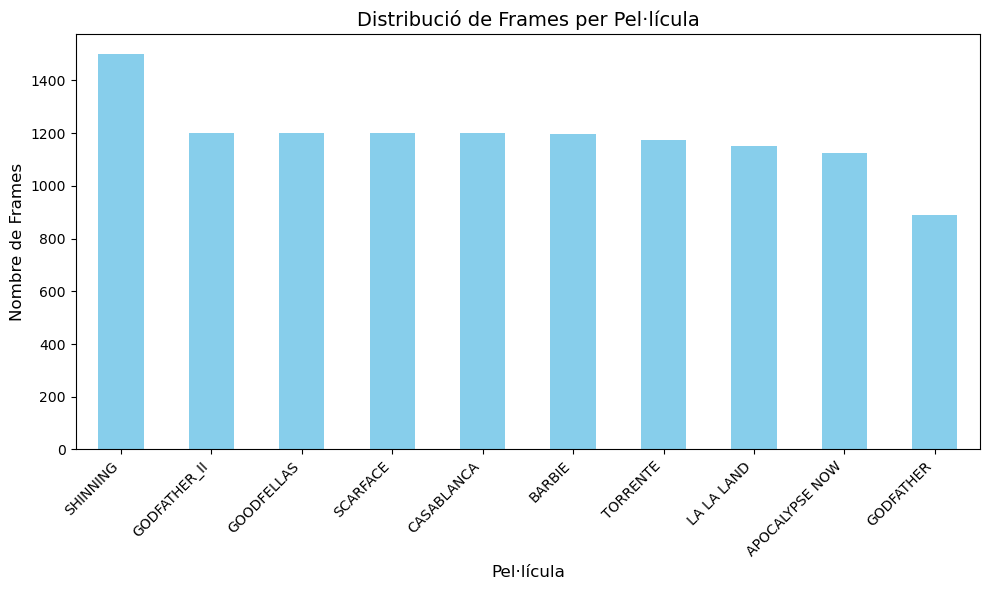

In [8]:
import matplotlib.pyplot as plt

# Gràfic de barres per la distribució
plt.figure(figsize=(10, 6))
distribucio_frames.plot(kind='bar', color='skyblue')
plt.title("Distribució de Frames per Pel·lícula", fontsize=14)
plt.xlabel("Pel·lícula", fontsize=12)
plt.ylabel("Nombre de Frames", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


### Tractament de Frames Negres com a Dades Nul·les

En aquest projecte, tot i que la base de dades no conté valors nuls tradicionals, hem identificat frames amb imatges totalment negres, generalment deguts a transicions entre escenes o fossos en negre. Tractarem aquestes imatges com a NaNs, ja que no aporten informació visual significativa per a l'anàlisi o l'entrenament del model. Aquest criteri ens permet gestionar de manera efectiva les dades menys útils dins del dataset.


In [20]:
from collections import Counter

# Detecció de NaNs
missing_values = []
count = 0
brillantor = df["Brillantor_promig"]
pelicula = df["pel·licula"]

for i in range(len(brillantor)):
    if brillantor[i] <= 5:  # Considerem NaNs si el valor és <= 5
        count += 1
        missing_values.append(pelicula[i])

print("Tenim un total de", count, "NaNs")

# Comptar el nombre de NaNs per pel·lícula
compt = Counter(missing_values)

# Incloure totes les pel·lícules, encara que no tinguin NaNs
pelicules_totals = df['pel·licula'].unique()
pelicules = list(pelicules_totals)
num_nans = [compt[pelicula] if pelicula in compt else 0 for pelicula in pelicules]

# Mostrar resultats
print("Nombre de NaNs per pel·lícula:")
for pelicula, num in zip(pelicules, num_nans):
    print(f"{pelicula}: {num} NaNs")


Tenim un total de 192 NaNs
Nombre de NaNs per pel·lícula:
GODFATHER: 70 NaNs
GODFATHER_II: 0 NaNs
GOODFELLAS: 0 NaNs
SCARFACE: 0 NaNs
TORRENTE: 4 NaNs
APOCALYPSE NOW: 68 NaNs
BARBIE: 10 NaNs
CASABLANCA: 17 NaNs
SHINNING: 16 NaNs
LA LA LAND: 7 NaNs


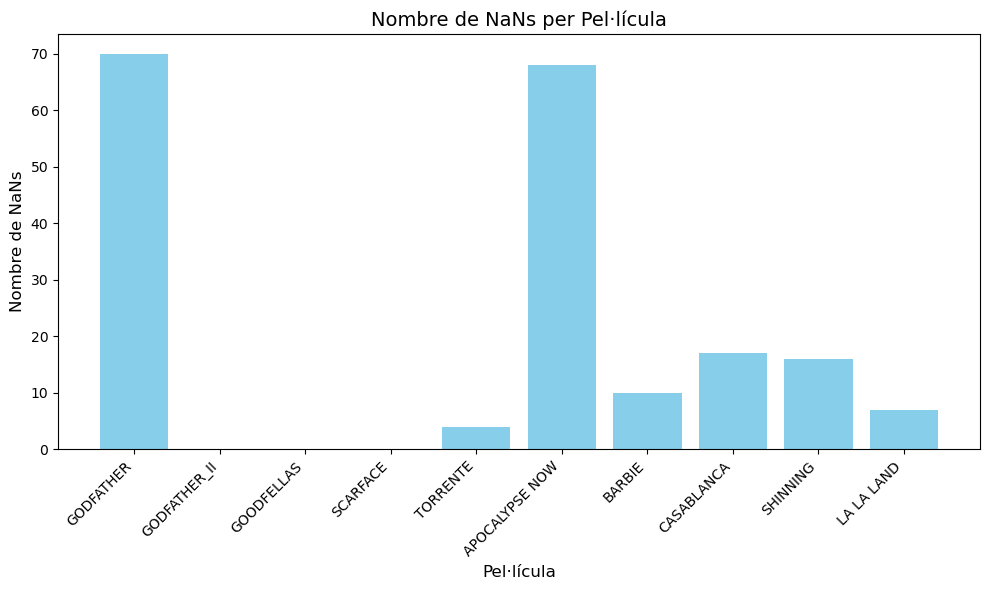

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

# Preparar les dades
pelicules_totals = df['pel·licula'].unique()  # Llista completa de pel·lícules
pelicules = list(pelicules_totals)  # Convertir a llista
num_nans = [compt[pelicula] if pelicula in compt else 0 for pelicula in pelicules]  # Comptar NaNs o assignar 0

# Generar el gràfic de barres
plt.figure(figsize=(10, 6))
plt.bar(pelicules, num_nans, color='skyblue')  # Utilitzem les dades de pel·lícules i NaNs
plt.title("Nombre de NaNs per Pel·lícula", fontsize=14)
plt.xlabel("Pel·lícula", fontsize=12)
plt.ylabel("Nombre de NaNs", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotació dels noms de les pel·lícules
plt.tight_layout()
plt.show()


In [ ]:
#Eliminem NaNS
indexos_amb_NaNs=df[df["Brillantor_promig"]<=5].index
df=df.drop(indexos_amb_NaNs)
NaNs=(df["Brillantor_promig"]<=5).sum()
print(NaNs)